# Voice Identification Experiment 1

This is the ipynb file for the Digital Signal Processing Experiment.

## Data Preprocessing 

I choose to use the simple endpoint detection to simplify the classification process. To be more specific, I choose to ignore all the noize data whose absolute value is lower than 0.05.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


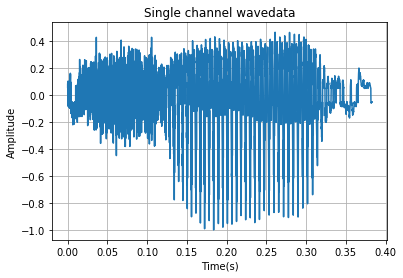

In [3]:
import wave
import matplotlib.pyplot as plt
import numpy as np
import os
 
#filepath = "" #添加路径
filename = 'ryan71.wav'
#filename= os.listdir(filepath) #得到文件夹下的所有文件名称 
f = wave.open(filename,'rb')
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
strData = f.readframes(nframes)#读取音频，字符串格式
waveData = np.fromstring(strData,dtype=np.int16)#将字符串转化为int
waveData = waveData*1.0/(max(abs(waveData)))#wave幅值归一化
Data = []
j = 0
for i in range(len(waveData)):
    if abs(waveData[i]) > 0.05:
        Data.append(waveData[i])
        j+=1
    
# plot the wave
time = np.arange(0,j)*(1.0 / framerate)
plt.plot(time,Data)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Single channel wavedata")
plt.grid('on')#标尺，on：有，off:无。

Firstly we try to preprocess the wavedata using multiple method.

## Enframe, Energy and ZCR

In this code, I use only 2 wav file to test the program which contains the voice information of zero and seven. I used function using double gate algorithms to detect the endpoints of voice and counting the Energy and ZCR to find different features of voice information. The figures of different features are shown below. 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


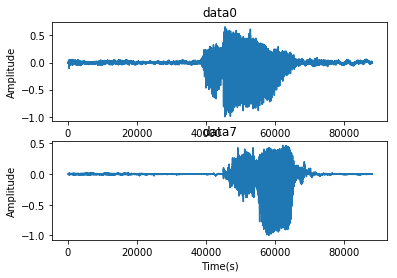

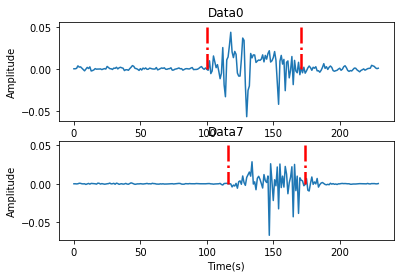

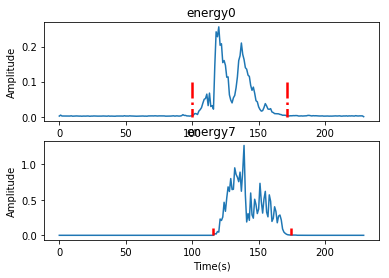

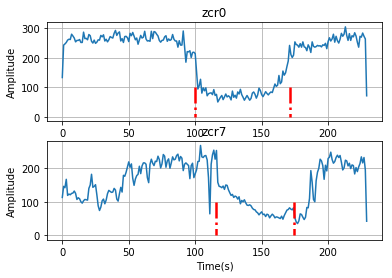

In [5]:
import numpy as np
import wave
import os
import math
import scipy.signal as signal

def Enframe(wavData, frameSize, overlap):
    coeff = 0.97 # 预加重系数
    wlen = len(wavData)
    step = frameSize - overlap
    frameNum = math.ceil(wlen / step)
    frameData = np.zeros((frameSize, frameNum))

    hamwin = np.hamming(frameSize)

    for i in range(frameNum):
        singleFrame = wavData[np.arange(i * step, min(i * step + frameSize, wlen))]
        singleFrame = np.append(singleFrame[0], singleFrame[:-1] - coeff * singleFrame[1:]) # 预加重
        frameData[:len(singleFrame), i] = singleFrame
        frameData[:, i] = hamwin * frameData[:, i] # 加窗

    return frameData

def wavread(filename):
    f = wave.open(filename,'rb')
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    strData = f.readframes(nframes)#读取音频，字符串格式
    waveData = np.fromstring(strData,dtype=np.int16)#将字符串转化为int
    f.close()
    waveData = waveData*1.0/(max(abs(waveData)))#wave幅值归一化
    waveData = np.reshape(waveData,[nframes,nchannels]).T
    return waveData

# 计算每一帧的过零率
def ZCR(frameData):
    frameNum = frameData.shape[1]
    frameSize = frameData.shape[0]
    zcr = np.zeros((frameNum, 1))

    for i in range(frameNum):
        singleFrame = frameData[:, i]
        temp = singleFrame[:frameSize-1] * singleFrame[1:frameSize]
        temp = np.sign(temp)
        zcr[i] = np.sum(temp<0)

    return zcr


# 计算每一帧能量
def energy(frameData):
    frameNum = frameData.shape[1]

    ener = np.zeros((frameNum, 1))

    for i in range(frameNum):
        singleframe = frameData[:, i]
        ener[i] = sum(singleframe * singleframe)

    return ener

#新增的利用双门限法的语音端点检测
def VAD(energy):
    High = 0.05
    Low = 0.004
    Data1 = []
    Endpoint = []
    for i in range(len(energy)):
        if energy[i] > High:
            Data1.append(i)
    num = Data1[0]
    while num > 0:
        if energy[num] < Low:
            Endpoint.append(num)
            break
        num -= 1
    num = Data1[len(Data1)-1]
    while num < len(energy):
        if energy[num] < Low:
            Endpoint.append(num)
            break
        num += 1
    return Endpoint
        
#filepath = "./data/" #添加路径
#dirname= os.listdir(filepath) #得到文件夹下的所有文件名称 
#filename = filepath+dirname[0]
filename7 = "ryan71.wav"
filename0 = "ryan02.wav"
data0 = wavread(filename0)
data7 = wavread(filename7)
nw = 512
inc = 128
winfunc = signal.hamming(nw)
#Frame = enframe(data[0], nw, inc, winfunc)
Frame0 = Enframe(data0[0], nw, inc) 
Frame7 = Enframe(data7[0], nw, inc)
Energy0 = energy(Frame0)
zcr0 = ZCR(Frame0)
Energy7 = energy(Frame7)
zcr7 = ZCR(Frame7)
time = np.arange(0,nframes)*(1.0 / framerate)
endpoint = VAD(Energy0)
endpoint2 = VAD(Energy7)
plt.figure(1)
plt.subplot(211)
plt.plot(data0[0])
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("data0")
plt.subplot(212)
plt.plot(data7[0])
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("data7")
plt.figure(2)
plt.subplot(211)
plt.plot(Frame0[0])
plt.plot([endpoint[0], endpoint[0]], [0.05,0], 'r-.', lw= 2.5)
plt.plot([endpoint[1], endpoint[1]], [0.05,0], 'r-.', lw= 2.5)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Data0")
plt.subplot(212)
plt.plot(Frame7[0])
plt.plot([endpoint2[0], endpoint2[0]], [0.05,0], 'r-.', lw= 2.5)
plt.plot([endpoint2[1], endpoint2[1]], [0.05,0], 'r-.', lw= 2.5)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Data7")
plt.figure(3)
plt.subplot(211)
plt.plot(Energy0)
plt.plot([endpoint[0], endpoint[0]], [0.1,0], 'r-.', lw= 2.5)
plt.plot([endpoint[1], endpoint[1]], [0.1,0], 'r-.', lw= 2.5)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("energy0")
plt.subplot(212)
plt.plot(Energy7)
plt.plot([endpoint2[0], endpoint2[0]], [0.1,0], 'r-.', lw= 2.5)
plt.plot([endpoint2[1], endpoint2[1]], [0.1,0], 'r-.', lw= 2.5)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("energy7")
plt.figure(4)
plt.subplot(211)
plt.plot(zcr0)
plt.plot([endpoint[0], endpoint[0]], [100,0], 'r-.', lw= 2.5)
plt.plot([endpoint[1], endpoint[1]], [100,0], 'r-.', lw= 2.5)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("zcr0")
plt.grid('on')#标尺，on：有，off:无。
plt.subplot(212)
plt.plot(zcr7)
plt.plot([endpoint2[0], endpoint2[0]], [100,0], 'r-.', lw= 2.5)
plt.plot([endpoint2[1], endpoint2[1]], [100,0], 'r-.', lw= 2.5)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("zcr7")


plt.grid('on')#标尺，on：有，off:无。